<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Assignment 10</center><h2>

**Instructor** : Dr. C. Lee Giles <br>
**TA** : Neisarg Dave, Shaurya Rohatgi
<br><br>

Credits: 

<h3>Course Policy<h3>

Carefully read all the instructions, before you start working on the assignment

* Give maximum explanation for each sub-problems.

* Assignments are due before class at Monday 05:59:59 pm. Please check the due date on the official course webportalg Portal.

* Please avoid single line answers, submissions without any explanations would receive 0 points.

* Late submissions will be graded with 20% discount per day. Day 1 starts immediately after the submission deadline.

* Every assignment has a hard deadline, usually 3 days past the original due date, i.e. Thursday after the due Monday

* Late submissions (penalty or not) are not accepted after the hard deadline.

* All source materials must be cited. The University Academic Code of Conduct will be strictly enforced.

* We will be creating Canvas submission page for this. Submit all files on Canvas.

* All queries related to Assignment should have a subject line *IST597:Assignment_10 Queries*

---


<h2><center>Multi Layer Perceptron</center><h2>

Multiplayer Perceptron is a feed forward neural network composed of multiple layers of affine transformations followed by non linearity function. Each layer of an MLP is defined as:
$$
z^{(l)} = W^{(l)}x^{(l-1)} + b^{(l)}
$$ 

$$
x^{(l)} = f(z^{(l)})
$$

Here, $l$ denotes the layer of MLP, $W$ and $b$ are the trainable parameters called *weight* and *bias* respectively

ReLU or Rectified Linear Unit is the most common non linear layer used with MLP.
More about ReLU can be found here: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

In this assignment you are required to do the following:

+ Create an MLP
  + Write the *forward* function for affine transformation
  + Write the *backward* function (to calculate gradients) for the affine transformation
  + Create a Neural Network by stacking these transformations

+ Train the Neural Network on Fashion MNIST Dataset
  + Write Loss Function for the training
  + Write parameter update routine
  + Run Validation 
  + Plot Train and Validation Loss Curves using Matplotlib 

+ Testing the Neural Network
  + Change the *seed* and train the neural network 10 times
  + Report the mean and variance over 10 trials on the following metrics:
    + Accuracy
    + Precision
    + Recall
    + F1
    + ROC curve

+ Change the number of parameters in the Neural Network 
  + Train a underfit model
  + Train a overfit model
  + Demostrate the difference between overfitting and underfitting


In [29]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
# select device as cuda
device = torch.device("cuda:0")
# set random seeds
seed = 1234 ## change this seed when you run trials
random.seed(seed)
torch.manual_seed(seed)

### Gradient Update
To update gradients, from the equation of affine transformation we have:

$$
z^{(l)} = W^{(l)}x^{(l-1)} + b
$$ 

We can calulate all the partial derivations in the following fashion

$$
\frac{\partial z^{(l)}}{\partial x^{(l-1)}} = W^{(l)}
$$

$$
\frac{\partial z^{(l)}}{\partial W^{(l)}} = x^{(l-1)}
$$

$$
\frac{\partial z^{(l)}}{\partial b^{(l)}} = 1
$$

To write the *backward* function, we need one more step. *backward* functon takes *grad_output* as its input. It is the backward flow of gradients coming from the final output $\hat y$ and can be mathematically expressed as:
$$
  grad\_output = \frac{\partial \hat y}{\partial z^{(l)}}
$$

*backward* functions gives out three values:

$$
grad\_x = \frac{\partial \hat y}{\partial x^{(l-1)}} = \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial x^{(l-1)}} 
$$

$$
grad\_w = \frac{\partial \hat y}{\partial W^{(l)}} = \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial W^{(l)}}
$$


$$
grad\_b = \frac{\partial \hat y}{\partial b^{(l)}} =  \frac{\partial \hat y}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b^{(l)}}
$$

In the code below, update the *forward* and *backward* functions of class LinearFunction


In [30]:
class LinearFunction(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, W, b):
    """
    # x -> input matrix of size n_samples x sdim
    # W -> transformation matrix
    # b -> bias term 
    """
    ctx.save_for_backward(x, W, b)
    # Write your affine transformation here:
    #-------------------
    z = x.mm(W) + b
    #-------------------
    return z
    
  @staticmethod
  def backward(ctx, grad_output):
    x, W, b = ctx.saved_tensors
   
    # Write gradient updates here:
    #----------------------------
    grad_x = grad_output.mm(W.t())
    grad_w = x.t().mm(grad_output)
    grad_b = grad_output.sum(0)
    #-----------------------------
    return grad_x, grad_w, grad_b

Class CustomLinearLayer uses previously defined LinearFunction to create one layer of Neural Network. Look at the initial values given to $W$ and $b$.
You do not need to change anything in this class.

In [31]:
class CustomLinearLayer(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super(CustomLinearLayer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    w = torch.normal(mean = 0, std = 0.1, size = [in_features, out_features], requires_grad=True)
    b = torch.full([out_features], 0.01, requires_grad=True)
    w = torch.nn.Parameter(w)
    b = torch.nn.Parameter(b)
    self.register_parameter('w', w)
    self.register_parameter('b', b)
    self.linear_function = LinearFunction.apply
  
  def forward(self, x):
    return self.linear_function(x, self.w, self.b)

In the Neural Network class below class Below, Add two linear layers of the following sizes:
+ 784 x 512
+ 512 x 10

In the forward function, 
+ Apply layer_1 on input
+ Apply activation function on the result
+ Apply layer_2 on the result
+ Apply Softmax and return the final result

In [32]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    # Add Linear layers below 
    #-----------------------------------
    self.layer_1 = torch.nn.Linear(in_features=784, out_features=512)
    self.layer_2 = torch.nn.Linear(in_features=512, out_features=10)
    # ------------------------------------
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    # Apply layers defined above:
    #-------------------------------
    x = self.layer_1(x)
    x = self.activation(x)
    x = self.layer_2(x)
    output = self.softmax(x)
    #-------------------------------
    return output

Fasion MNIST dataset is a set of grayscale images categorized into 10 classes. To train our neural network, first we need to define loss function. $y$ is the ground truth class label and $probs$ is the probability distribution given by our Neural Network over 10 classes, update the *forward* function of loss class below. 

$$
ce\_loss = -\frac{1}{{\#samples}}\sum^{\#samples}_i y_i.\log(probs_i)
$$

*Hint*: Try representing $y$ as one hot vector

In [33]:
class CrossEntropyLoss(torch.nn.Module):
  def __init__(self):
    super(CrossEntropyLoss, self).__init__()
  
  def forward(self, probs, y):
    #Write loss function here:
    #-------------------------------
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=10)
    loss = -(y_one_hot*torch.log(probs)).mean()
    #loss = None
    #-------------------------------
    return loss

In [34]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

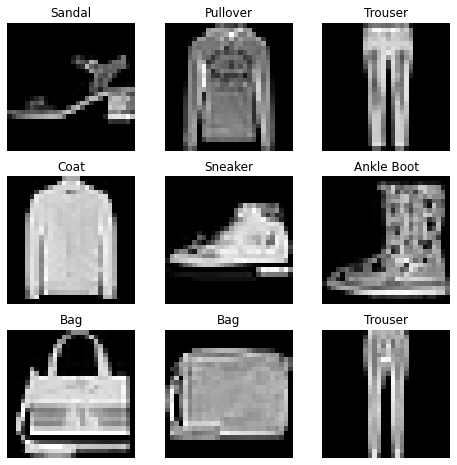

In [35]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Fashion MNIST dataset loaded from pytorch APIs only has two sets: train and test. Split the train data into train and validation sets with 50K samples in train and 10K samples in validation set. The data split should be random.

*Hint* Look for a function in *torch.utils.data*

In [36]:
# split mnist trainset into two sets: mnist trainset -> 50000 , mnist validation set -> 10000
#----------------
train_data, val_data = torch.utils.data.random_split(training_data, [50000, 10000])
#----------------

In [37]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [41]:
model = NeuralNetwork()
ce_loss = CrossEntropyLoss()

1) The gradients we calculated in the start can be accessed by iterating over model.parameters() as *params.grad*. Write the parameter update rule in the training code below: 

$$
param := param - learning\_rate*gradient
$$

2) Write validation loop which runs every epoch and prints the following metrics on validation set:
  + Accuracy
  + Precision
  + Recall
  + F1 
  + roc_auc

3) Store the training loss and validation loss in each iteration and plot a graph comparing them.

Testing the Neural Network
  + Change the *seed* and train the neural network 10 times
  + Report the mean and variance over 10 trials on the following metrics:
    + Accuracy
    + Precision
    + Recall
    + F1
    + ROC curve



Epoch 0/10 Iteration 0/49 Loss : 0.23175406455993652 
Epoch 0/10 Iteration 1/49 Loss : 0.2322165071964264 
Epoch 0/10 Iteration 2/49 Loss : 0.2323605716228485 
Epoch 0/10 Iteration 3/49 Loss : 0.23156733810901642 
Epoch 0/10 Iteration 4/49 Loss : 0.23203790187835693 
Epoch 0/10 Iteration 5/49 Loss : 0.23233482241630554 
Epoch 0/10 Iteration 6/49 Loss : 0.23146574199199677 
Epoch 0/10 Iteration 7/49 Loss : 0.23171278834342957 
Epoch 0/10 Iteration 8/49 Loss : 0.2311050146818161 
Epoch 0/10 Iteration 9/49 Loss : 0.23179873824119568 
Epoch 0/10 Iteration 10/49 Loss : 0.2315022051334381 
Epoch 0/10 Iteration 11/49 Loss : 0.231502965092659 
Epoch 0/10 Iteration 12/49 Loss : 0.230952650308609 
Epoch 0/10 Iteration 13/49 Loss : 0.23130600154399872 
Epoch 0/10 Iteration 14/49 Loss : 0.23176446557044983 
Epoch 0/10 Iteration 15/49 Loss : 0.23093076050281525 
Epoch 0/10 Iteration 16/49 Loss : 0.23125982284545898 
Epoch 0/10 Iteration 17/49 Loss : 0.23115643858909607 
Epoch 0/10 Iteration 18/49 L

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.25      0.03      0.06       116
           2       0.06      0.01      0.02        84
           3       0.00      0.00      0.00        92
           4       0.17      0.29      0.21        89
           5       0.00      0.00      0.00       127
           6       0.00      0.00      0.00       119
           7       0.00      0.00      0.00       108
           8       0.24      0.37      0.29        98
           9       0.10      0.73      0.17        90

    accuracy                           0.13      1024
   macro avg       0.08      0.14      0.08      1024
weighted avg       0.08      0.13      0.07      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.09      0.01      0.02       100
           2       0.00      0.00      0.00       112
           3       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.07      0.01      0.02       115
           2       0.00      0.00      0.00        94
           3       0.00      0.00      0.00       111
           4       0.17      0.26      0.21       116
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00       104
           8       0.22      0.36      0.27       101
           9       0.10      0.73      0.18        91

    accuracy                           0.13      1024
   macro avg       0.06      0.13      0.07      1024
weighted avg       0.06      0.13      0.07      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.20      0.02      0.04       123
           2       0.00      0.00      0.00        93
           3       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.00      0.00      0.00        76
           2       0.11      0.01      0.02       113
           3       0.00      0.00      0.00       100
           4       0.16      0.25      0.20       102
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       101
           7       0.00      0.00      0.00       103
           8       0.14      0.25      0.18        87
           9       0.13      0.72      0.21       119

    accuracy                           0.13      1024
   macro avg       0.05      0.12      0.06      1024
weighted avg       0.06      0.13      0.06      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.21      0.03      0.06        90
           2       0.08      0.01      0.02       103
           3       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.20      0.02      0.03       108
           2       0.00      0.00      0.00        97
           3       0.00      0.00      0.00       111
           4       0.21      0.32      0.26       114
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        87
           7       0.00      0.00      0.00       117
           8       0.22      0.32      0.26       108
           9       0.11      0.67      0.18       104

    accuracy                           0.14      1024
   macro avg       0.07      0.13      0.07      1024
weighted avg       0.08      0.14      0.08      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.07      0.01      0.02       113
           2       0.00      0.00      0.00        92
           3       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.17      0.01      0.02        79
           2       0.20      0.02      0.03       106
           3       0.00      0.00      0.00       101
           4       0.25      0.36      0.30       120
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00        95
           8       0.20      0.26      0.23       103
           9       0.12      0.76      0.20       107

    accuracy                           0.15      1024
   macro avg       0.09      0.14      0.08      1024
weighted avg       0.10      0.15      0.08      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.57      0.05      0.09        78
           2       0.14      0.01      0.02        76
           3       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.38      0.05      0.09       100
           2       0.19      0.04      0.07       112
           3       1.00      0.01      0.02       107
           4       0.21      0.74      0.32       108
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00        84
           7       0.00      0.00      0.00        95
           8       0.29      0.35      0.31       118
           9       0.17      0.86      0.28        90

    accuracy                           0.20      1024
   macro avg       0.22      0.20      0.11      1024
weighted avg       0.23      0.20      0.11      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.54      0.06      0.11       115
           2       0.04      0.01      0.02        94
           3       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.57      0.10      0.17       123
           2       0.07      0.02      0.03        93
           3       0.50      0.01      0.02       112
           4       0.21      0.79      0.33       107
           5       0.00      0.00      0.00       101
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00        77
           8       0.29      0.44      0.35        98
           9       0.19      0.84      0.32        97

    accuracy                           0.22      1024
   macro avg       0.18      0.22      0.12      1024
weighted avg       0.20      0.22      0.12      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.71      0.07      0.12        76
           2       0.21      0.04      0.07       113
           3       0.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.42      0.06      0.10        90
           2       0.16      0.04      0.06       103
           3       0.00      0.00      0.00        89
           4       0.22      0.75      0.33       106
           5       0.00      0.00      0.00       109
           6       0.00      0.00      0.00       108
           7       0.00      0.00      0.00        89
           8       0.30      0.38      0.34       117
           9       0.21      0.83      0.33       116

    accuracy                           0.22      1024
   macro avg       0.13      0.21      0.12      1024
weighted avg       0.13      0.22      0.13      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.54      0.06      0.12       108
           2       0.03      0.01      0.02        97
           3       0.25 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.47      0.08      0.14       113
           2       0.11      0.04      0.06        92
           3       1.00      0.01      0.02       114
           4       0.22      0.82      0.34        98
           5       0.00      0.00      0.00        84
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00       112
           8       0.30      0.43      0.36       107
           9       0.19      0.87      0.31        98

    accuracy                           0.22      1024
   macro avg       0.23      0.22      0.12      1024
weighted avg       0.24      0.22      0.12      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.71      0.13      0.22        79
           2       0.17      0.04      0.06       106
           3       1.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

Epoch 2/10 Iteration 0/49 Loss : 0.2248247116804123 
Epoch 2/10 Iteration 1/49 Loss : 0.2251770943403244 
Epoch 2/10 Iteration 2/49 Loss : 0.22522945702075958 
Epoch 2/10 Iteration 3/49 Loss : 0.22476725280284882 
Epoch 2/10 Iteration 4/49 Loss : 0.22505052387714386 
Epoch 2/10 Iteration 5/49 Loss : 0.22532550990581512 
Epoch 2/10 Iteration 6/49 Loss : 0.22437798976898193 
Epoch 2/10 Iteration 7/49 Loss : 0.2245848923921585 
Epoch 2/10 Iteration 8/49 Loss : 0.22456972301006317 
Epoch 2/10 Iteration 9/49 Loss : 0.2251882255077362 
Epoch 2/10 Iteration 10/49 Loss : 0.2245728075504303 
Epoch 2/10 Iteration 11/49 Loss : 0.22493121027946472 
Epoch 2/10 Iteration 12/49 Loss : 0.22406573593616486 
Epoch 2/10 Iteration 13/49 Loss : 0.22454051673412323 
Epoch 2/10 Iteration 14/49 Loss : 0.2252238690853119 
Epoch 2/10 Iteration 15/49 Loss : 0.223947212100029 
Epoch 2/10 Iteration 16/49 Loss : 0.22462813556194305 
Epoch 2/10 Iteration 17/49 Loss : 0.22438354790210724 
Epoch 2/10 Iteration 18/49 L

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.69      0.18      0.29       100
           2       0.36      0.17      0.23       112
           3       0.83      0.09      0.17       107
           4       0.22      0.94      0.35       108
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00        84
           7       0.00      0.00      0.00        95
           8       0.42      0.47      0.44       118
           9       0.24      0.90      0.38        90

    accuracy                           0.28      1024
   macro avg       0.28      0.28      0.19      1024
weighted avg       0.29      0.28      0.19      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.76      0.19      0.31       115
           2       0.18      0.09      0.12        94
           3       1.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       114
           1       0.77      0.24      0.37       123
           2       0.13      0.08      0.10        93
           3       0.67      0.04      0.07       112
           4       0.20      0.95      0.33       107
           5       0.00      0.00      0.00       101
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00        77
           8       0.40      0.49      0.44        98
           9       0.30      0.93      0.45        97

    accuracy                           0.28      1024
   macro avg       0.30      0.27      0.18      1024
weighted avg       0.32      0.28      0.18      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.69      0.24      0.35        76
           2       0.25      0.10      0.14       113
           3       0.71 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      0.01      0.02        97
           1       0.76      0.18      0.29        90
           2       0.13      0.06      0.08       103
           3       1.00      0.02      0.04        89
           4       0.21      0.92      0.34       106
           5       0.00      0.00      0.00       109
           6       0.00      0.00      0.00       108
           7       0.00      0.00      0.00        89
           8       0.41      0.48      0.44       117
           9       0.31      0.91      0.46       116

    accuracy                           0.28      1024
   macro avg       0.38      0.26      0.17      1024
weighted avg       0.37      0.28      0.18      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.79      0.24      0.37       108
           2       0.18      0.10      0.13        97
           3       0.12 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       104
           1       0.63      0.24      0.35       113
           2       0.18      0.12      0.14        92
           3       0.83      0.04      0.08       114
           4       0.20      0.93      0.33        98
           5       0.00      0.00      0.00        84
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00       112
           8       0.41      0.50      0.45       107
           9       0.29      0.94      0.44        98

    accuracy                           0.27      1024
   macro avg       0.35      0.28      0.18      1024
weighted avg       0.37      0.27      0.18      1024

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.69      0.25      0.37        79
           2       0.28      0.11      0.16       106
           3       1.00 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.48      0.18      0.26        78
           2       0.32      0.14      0.20        76
           3       0.33      0.01      0.02        82
           4       0.19      0.92      0.32        71
           5       0.00      0.00      0.00        77
           6       0.00      0.00      0.00        88
           7       0.00      0.00      0.00        80
           8       0.31      0.42      0.36        69
           9       0.29      0.89      0.44        91

    accuracy                           0.26       784
   macro avg       0.19      0.26      0.16       784
weighted avg       0.19      0.26      0.16       784

----------------------------------
Epoch 2/10 Validation Loss : 0.22258177399635315 ;
Epoch 2/10 Validation Accuracy : 27.700000000000003 %
Epoch 2/10 Validation Recall : 0.6
Epoch 2/10 Validation Precision : 1.0
Epoch 2/10 Validation F1 Sco

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.60      0.03      0.06       101
           1       0.83      0.45      0.58       116
           2       0.15      0.11      0.12        84
           3       0.81      0.23      0.36        92
           4       0.19      0.97      0.32        89
           5       0.00      0.00      0.00       127
           6       0.00      0.00      0.00       119
           7       0.00      0.00      0.00       108
           8       0.53      0.60      0.56        98
           9       0.29      0.99      0.45        90

    accuracy                           0.31      1024
   macro avg       0.34      0.34      0.24      1024
weighted avg       0.33      0.31      0.23      1024

              precision    recall  f1-score   support

           0       0.25      0.01      0.02        99
           1       0.77      0.37      0.50       100
           2       0.33      0.17      0.22       112
           3       0.85 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.40      0.04      0.08        92
           1       0.80      0.35      0.48       115
           2       0.22      0.13      0.16        94
           3       0.86      0.16      0.27       111
           4       0.23      0.97      0.37       116
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00       104
           8       0.60      0.64      0.62       101
           9       0.29      0.95      0.45        91

    accuracy                           0.33      1024
   macro avg       0.34      0.32      0.24      1024
weighted avg       0.35      0.33      0.25      1024

              precision    recall  f1-score   support

           0       0.60      0.03      0.05       114
           1       0.81      0.42      0.56       123
           2       0.19      0.12      0.15        93
           3       0.75 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.60      0.05      0.10       112
           1       0.85      0.45      0.59        76
           2       0.24      0.12      0.16       113
           3       0.89      0.17      0.29       100
           4       0.20      0.92      0.33       102
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       101
           7       0.00      0.00      0.00       103
           8       0.44      0.53      0.48        87
           9       0.35      0.94      0.51       119

    accuracy                           0.32      1024
   macro avg       0.36      0.32      0.25      1024
weighted avg       0.34      0.32      0.23      1024

              precision    recall  f1-score   support

           0       0.88      0.07      0.13        97
           1       0.77      0.37      0.50        90
           2       0.24      0.13      0.17       103
           3       0.93 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.71      0.05      0.10        93
           1       0.84      0.45      0.59       108
           2       0.21      0.14      0.17        97
           3       0.58      0.10      0.17       111
           4       0.23      0.89      0.36       114
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        87
           7       0.00      0.00      0.00       117
           8       0.61      0.59      0.60       108
           9       0.32      0.96      0.48       104

    accuracy                           0.34      1024
   macro avg       0.35      0.32      0.25      1024
weighted avg       0.36      0.34      0.26      1024

              precision    recall  f1-score   support

           0       0.50      0.05      0.09       104
           1       0.75      0.41      0.53       113
           2       0.21      0.14      0.17        92
           3       0.92 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.29      0.02      0.04       100
           1       0.77      0.34      0.47        79
           2       0.30      0.13      0.18       106
           3       0.96      0.22      0.35       101
           4       0.24      0.96      0.38       120
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00        95
           8       0.53      0.55      0.54       103
           9       0.33      0.98      0.50       107

    accuracy                           0.33      1024
   macro avg       0.34      0.32      0.25      1024
weighted avg       0.33      0.33      0.24      1024

              precision    recall  f1-score   support

           0       0.43      0.04      0.08        72
           1       0.63      0.40      0.49        78
           2       0.32      0.18      0.23        76
           3       0.67 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.63      0.17      0.27       101
           1       0.90      0.63      0.74       116
           2       0.19      0.13      0.16        84
           3       0.84      0.35      0.49        92
           4       0.21      0.96      0.34        89
           5       0.00      0.00      0.00       127
           6       0.00      0.00      0.00       119
           7       0.00      0.00      0.00       108
           8       0.59      0.64      0.61        98
           9       0.29      1.00      0.45        90

    accuracy                           0.36      1024
   macro avg       0.37      0.39      0.31      1024
weighted avg       0.36      0.36      0.30      1024

              precision    recall  f1-score   support

           0       0.75      0.18      0.29        99
           1       0.84      0.59      0.69       100
           2       0.40      0.18      0.25       112
           3       0.86 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.59      0.18      0.28        92
           1       0.88      0.60      0.72       115
           2       0.30      0.17      0.22        94
           3       0.88      0.25      0.39       111
           4       0.25      0.97      0.40       116
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00       104
           8       0.70      0.66      0.68       101
           9       0.30      0.96      0.46        91

    accuracy                           0.39      1024
   macro avg       0.39      0.38      0.31      1024
weighted avg       0.40      0.39      0.32      1024

              precision    recall  f1-score   support

           0       0.72      0.11      0.20       114
           1       0.90      0.59      0.71       123
           2       0.29      0.17      0.21        93
           3       0.70 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.63      0.20      0.30       112
           1       0.91      0.70      0.79        76
           2       0.30      0.14      0.19       113
           3       0.93      0.28      0.43       100
           4       0.22      0.92      0.35       102
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       101
           7       0.00      0.00      0.00       103
           8       0.53      0.60      0.56        87
           9       0.36      0.97      0.53       119

    accuracy                           0.37      1024
   macro avg       0.39      0.38      0.32      1024
weighted avg       0.37      0.37      0.30      1024

              precision    recall  f1-score   support

           0       0.75      0.22      0.34        97
           1       0.85      0.51      0.64        90
           2       0.32      0.17      0.23       103
           3       0.82 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.58      0.15      0.24        93
           1       0.89      0.69      0.78       108
           2       0.23      0.16      0.19        97
           3       0.68      0.21      0.32       111
           4       0.25      0.89      0.39       114
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        87
           7       0.00      0.00      0.00       117
           8       0.69      0.64      0.66       108
           9       0.34      0.98      0.50       104

    accuracy                           0.39      1024
   macro avg       0.37      0.37      0.31      1024
weighted avg       0.38      0.39      0.32      1024

              precision    recall  f1-score   support

           0       0.71      0.16      0.27       104
           1       0.84      0.51      0.64       113
           2       0.26      0.16      0.20        92
           3       0.94 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.59      0.18      0.28        72
           1       0.83      0.56      0.67        78
           2       0.37      0.22      0.28        76
           3       0.81      0.37      0.50        82
           4       0.21      0.96      0.35        71
           5       0.00      0.00      0.00        77
           6       0.00      0.00      0.00        88
           7       0.00      0.00      0.00        80
           8       0.55      0.57      0.56        69
           9       0.36      0.93      0.52        91

    accuracy                           0.38       784
   macro avg       0.37      0.38      0.32       784
weighted avg       0.37      0.38      0.31       784

----------------------------------
Epoch 4/10 Validation Loss : 0.21684905886650085 ;
Epoch 4/10 Validation Accuracy : 37.99 %
Epoch 4/10 Validation Recall : 0.9943181818181818
Epoch 4/10 Validation Precision : 1.0
Epoch 4/10 Validation F1 S

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.72      0.34      0.46       101
           1       0.92      0.71      0.80       116
           2       0.26      0.18      0.21        84
           3       0.82      0.40      0.54        92
           4       0.23      0.94      0.37        89
           5       0.00      0.00      0.00       127
           6       0.00      0.00      0.00       119
           7       0.00      0.00      0.00       108
           8       0.66      0.73      0.70        98
           9       0.29      1.00      0.45        90

    accuracy                           0.40      1024
   macro avg       0.39      0.43      0.35      1024
weighted avg       0.38      0.40      0.34      1024

              precision    recall  f1-score   support

           0       0.74      0.37      0.50        99
           1       0.87      0.67      0.76       100
           2       0.50      0.21      0.30       112
           3       0.83 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.59      0.26      0.36        92
           1       0.87      0.66      0.75       115
           2       0.39      0.23      0.29        94
           3       0.87      0.31      0.45       111
           4       0.27      0.96      0.42       116
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00       104
           8       0.77      0.71      0.74       101
           9       0.31      0.98      0.47        91

    accuracy                           0.42      1024
   macro avg       0.41      0.41      0.35      1024
weighted avg       0.42      0.42      0.36      1024

              precision    recall  f1-score   support

           0       0.78      0.22      0.34       114
           1       0.90      0.68      0.78       123
           2       0.35      0.23      0.27        93
           3       0.73 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.77      0.41      0.53       112
           1       0.94      0.78      0.85        76
           2       0.37      0.19      0.25       113
           3       0.95      0.37      0.53       100
           4       0.23      0.91      0.37       102
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       101
           7       0.00      0.00      0.00       103
           8       0.61      0.63      0.62        87
           9       0.37      0.97      0.53       119

    accuracy                           0.42      1024
   macro avg       0.42      0.43      0.37      1024
weighted avg       0.40      0.42      0.35      1024

              precision    recall  f1-score   support

           0       0.74      0.40      0.52        97
           1       0.89      0.66      0.76        90
           2       0.38      0.20      0.26       103
           3       0.82 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.71      0.37      0.48        93
           1       0.92      0.77      0.84       108
           2       0.28      0.18      0.22        97
           3       0.66      0.28      0.39       111
           4       0.27      0.89      0.41       114
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        87
           7       0.00      0.00      0.00       117
           8       0.73      0.69      0.71       108
           9       0.34      0.98      0.51       104

    accuracy                           0.43      1024
   macro avg       0.39      0.41      0.36      1024
weighted avg       0.40      0.43      0.37      1024

              precision    recall  f1-score   support

           0       0.71      0.34      0.46       104
           1       0.86      0.65      0.74       113
           2       0.32      0.20      0.24        92
           3       0.94 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.69      0.38      0.49       100
           1       0.88      0.67      0.76        79
           2       0.41      0.19      0.26       106
           3       0.88      0.36      0.51       101
           4       0.27      0.94      0.42       120
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00        95
           8       0.66      0.67      0.66       103
           9       0.35      0.98      0.51       107

    accuracy                           0.42      1024
   macro avg       0.41      0.42      0.36      1024
weighted avg       0.40      0.42      0.35      1024

              precision    recall  f1-score   support

           0       0.69      0.40      0.51        72
           1       0.87      0.67      0.75        78
           2       0.44      0.28      0.34        76
           3       0.81 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.68      0.51      0.58       101
           1       0.95      0.77      0.85       116
           2       0.33      0.21      0.26        84
           3       0.83      0.47      0.60        92
           4       0.25      0.94      0.40        89
           5       0.00      0.00      0.00       127
           6       0.00      0.00      0.00       119
           7       0.00      0.00      0.00       108
           8       0.70      0.80      0.75        98
           9       0.30      1.00      0.46        90

    accuracy                           0.44      1024
   macro avg       0.40      0.47      0.39      1024
weighted avg       0.39      0.44      0.37      1024

              precision    recall  f1-score   support

           0       0.75      0.48      0.59        99
           1       0.88      0.75      0.81       100
           2       0.54      0.24      0.33       112
           3       0.76 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.65      0.47      0.54        92
           1       0.95      0.77      0.85       115
           2       0.47      0.29      0.36        94
           3       0.85      0.40      0.54       111
           4       0.30      0.97      0.46       116
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       102
           7       0.00      0.00      0.00       104
           8       0.78      0.72      0.75       101
           9       0.31      0.98      0.47        91

    accuracy                           0.46      1024
   macro avg       0.43      0.46      0.40      1024
weighted avg       0.44      0.46      0.40      1024

              precision    recall  f1-score   support

           0       0.77      0.35      0.48       114
           1       0.92      0.78      0.85       123
           2       0.37      0.25      0.30        93
           3       0.71 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.77      0.56      0.65       112
           1       0.97      0.82      0.89        76
           2       0.37      0.19      0.25       113
           3       0.90      0.43      0.58       100
           4       0.25      0.89      0.39       102
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       101
           7       0.00      0.00      0.00       103
           8       0.67      0.67      0.67        87
           9       0.37      0.98      0.53       119

    accuracy                           0.45      1024
   macro avg       0.43      0.45      0.40      1024
weighted avg       0.41      0.45      0.38      1024

              precision    recall  f1-score   support

           0       0.75      0.57      0.65        97
           1       0.91      0.71      0.80        90
           2       0.37      0.21      0.27       103
           3       0.84 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        93
           1       0.95      0.83      0.89       108
           2       0.33      0.22      0.26        97
           3       0.69      0.33      0.45       111
           4       0.30      0.88      0.44       114
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        87
           7       0.00      0.00      0.00       117
           8       0.76      0.72      0.74       108
           9       0.34      0.99      0.51       104

    accuracy                           0.47      1024
   macro avg       0.41      0.45      0.39      1024
weighted avg       0.42      0.47      0.40      1024

              precision    recall  f1-score   support

           0       0.74      0.46      0.57       104
           1       0.88      0.74      0.80       113
           2       0.43      0.28      0.34        92
           3       0.92 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.67      0.53      0.59       100
           1       0.91      0.76      0.83        79
           2       0.50      0.25      0.34       106
           3       0.83      0.45      0.58       101
           4       0.31      0.93      0.46       120
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00        95
           8       0.69      0.73      0.71       103
           9       0.35      0.98      0.52       107

    accuracy                           0.47      1024
   macro avg       0.43      0.46      0.40      1024
weighted avg       0.41      0.47      0.39      1024

              precision    recall  f1-score   support

           0       0.69      0.57      0.63        72
           1       0.88      0.73      0.80        78
           2       0.48      0.32      0.38        76
           3       0.84 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       101
           1       0.97      0.83      0.89       116
           2       0.40      0.25      0.31        84
           3       0.78      0.53      0.63        92
           4       0.27      0.92      0.42        89
           5       0.00      0.00      0.00       127
           6       0.00      0.00      0.00       119
           7       1.00      0.01      0.02       108
           8       0.72      0.85      0.78        98
           9       0.30      1.00      0.46        90

    accuracy                           0.47      1024
   macro avg       0.51      0.50      0.41      1024
weighted avg       0.50      0.47      0.40      1024

              precision    recall  f1-score   support

           0       0.71      0.57      0.63        99
           1       0.93      0.83      0.88       100
           2       0.54      0.27      0.36       112
           3       0.77 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.66      0.61      0.63        92
           1       0.96      0.81      0.88       115
           2       0.47      0.31      0.37        94
           3       0.81      0.45      0.58       111
           4       0.34      0.96      0.50       116
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       102
           7       0.67      0.02      0.04       104
           8       0.79      0.76      0.77       101
           9       0.31      0.98      0.47        91

    accuracy                           0.50      1024
   macro avg       0.50      0.49      0.42      1024
weighted avg       0.51      0.50      0.43      1024

              precision    recall  f1-score   support

           0       0.74      0.47      0.58       114
           1       0.94      0.83      0.88       123
           2       0.40      0.29      0.34        93
           3       0.69 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       112
           1       0.99      0.87      0.92        76
           2       0.39      0.21      0.28       113
           3       0.85      0.50      0.63       100
           4       0.28      0.89      0.43       102
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       101
           7       0.00      0.00      0.00       103
           8       0.72      0.72      0.72        87
           9       0.36      0.98      0.53       119

    accuracy                           0.48      1024
   macro avg       0.44      0.49      0.42      1024
weighted avg       0.41      0.48      0.41      1024

              precision    recall  f1-score   support

           0       0.74      0.63      0.68        97
           1       0.92      0.72      0.81        90
           2       0.37      0.24      0.29       103
           3       0.80 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        93
           1       0.95      0.86      0.90       108
           2       0.39      0.30      0.34        97
           3       0.70      0.38      0.49       111
           4       0.32      0.87      0.47       114
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        87
           7       1.00      0.02      0.03       117
           8       0.75      0.71      0.73       108
           9       0.35      0.99      0.52       104

    accuracy                           0.49      1024
   macro avg       0.51      0.47      0.41      1024
weighted avg       0.54      0.49      0.42      1024

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       104
           1       0.89      0.81      0.85       113
           2       0.44      0.33      0.38        92
           3       0.87 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       100
           1       0.90      0.78      0.84        79
           2       0.57      0.32      0.41       106
           3       0.85      0.50      0.63       101
           4       0.34      0.93      0.50       120
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00       100
           7       1.00      0.01      0.02        95
           8       0.71      0.78      0.74       103
           9       0.35      0.98      0.52       107

    accuracy                           0.50      1024
   macro avg       0.54      0.49      0.43      1024
weighted avg       0.52      0.50      0.42      1024

              precision    recall  f1-score   support

           0       0.63      0.60      0.61        72
           1       0.90      0.77      0.83        78
           2       0.47      0.37      0.41        76
           3       0.80 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        99
           1       0.93      0.87      0.90       100
           2       0.57      0.31      0.40       112
           3       0.76      0.47      0.58       107
           4       0.33      0.90      0.48       108
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00        84
           7       0.83      0.05      0.10        95
           8       0.77      0.75      0.76       118
           9       0.31      0.99      0.47        90

    accuracy                           0.51      1024
   macro avg       0.52      0.50      0.44      1024
weighted avg       0.53      0.51      0.45      1024

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        92
           1       0.98      0.83      0.90       115
           2       0.46      0.33      0.39        94
           3       0.83 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.74      0.60      0.66       114
           1       0.95      0.85      0.90       123
           2       0.46      0.33      0.39        93
           3       0.68      0.46      0.55       112
           4       0.31      0.93      0.46       107
           5       0.00      0.00      0.00       101
           6       0.00      0.00      0.00       102
           7       1.00      0.01      0.03        77
           8       0.69      0.71      0.70        98
           9       0.37      0.99      0.54        97

    accuracy                           0.51      1024
   macro avg       0.52      0.49      0.42      1024
weighted avg       0.52      0.51      0.44      1024

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       112
           1       0.99      0.87      0.92        76
           2       0.43      0.27      0.33       113
           3       0.78 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.73      0.71      0.72        97
           1       0.95      0.78      0.85        90
           2       0.40      0.26      0.32       103
           3       0.77      0.48      0.59        89
           4       0.31      0.92      0.46       106
           5       0.00      0.00      0.00       109
           6       0.00      0.00      0.00       108
           7       1.00      0.04      0.09        89
           8       0.79      0.77      0.78       117
           9       0.39      1.00      0.56       116

    accuracy                           0.50      1024
   macro avg       0.53      0.50      0.44      1024
weighted avg       0.51      0.50      0.43      1024

              precision    recall  f1-score   support

           0       0.71      0.70      0.70        93
           1       0.96      0.87      0.91       108
           2       0.43      0.34      0.38        97
           3       0.74 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       104
           1       0.90      0.83      0.86       113
           2       0.49      0.40      0.44        92
           3       0.86      0.56      0.68       114
           4       0.31      0.91      0.47        98
           5       0.00      0.00      0.00        84
           6       0.00      0.00      0.00       102
           7       1.00      0.05      0.10       112
           8       0.84      0.80      0.82       107
           9       0.34      0.98      0.50        98

    accuracy                           0.52      1024
   macro avg       0.54      0.52      0.45      1024
weighted avg       0.57      0.52      0.47      1024

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       100
           1       0.91      0.80      0.85        79
           2       0.57      0.35      0.43       106
           3       0.82 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

----------------------------------
Epoch 8/10 Validation Loss : 0.20603987574577332 ;
Epoch 8/10 Validation Accuracy : 50.839999999999996 %
Epoch 8/10 Validation Recall : 0.9954682779456193
Epoch 8/10 Validation Precision : 0.9924698795180723
Epoch 8/10 Validation F1 Score : 0.9939668174962292
Epoch 8/10 Validation ROC_AUC Score : 0.9149401405472697
----------------------------------
Epoch 9/10 Iteration 0/49 Loss : 0.2048710286617279 
Epoch 9/10 Iteration 1/49 Loss : 0.20496587455272675 
Epoch 9/10 Iteration 2/49 Loss : 0.20486752688884735 
Epoch 9/10 Iteration 3/49 Loss : 0.2049655020236969 
Epoch 9/10 Iteration 4/49 Loss : 0.20490391552448273 
Epoch 9/10 Iteration 5/49 Loss : 0.2051864117383957 
Epoch 9/10 Iteration 6/49 Loss : 0.20399907231330872 
Epoch 9/10 Iteration 7/49 Loss : 0.2040964663028717 
Epoch 9/10 Iteration 8/49 Loss : 0.20514345169067383 
Epoch 9/10 Iteration 9/49 Loss : 0.20602793991565704 
Epoch 9/10 Iteration 10/49 Loss : 0.2047327756881714 
Epoch 9/10 Iteration 11

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.63      0.68      0.66       101
           1       0.98      0.86      0.92       116
           2       0.46      0.36      0.40        84
           3       0.76      0.60      0.67        92
           4       0.32      0.91      0.47        89
           5       0.00      0.00      0.00       127
           6       0.00      0.00      0.00       119
           7       1.00      0.07      0.14       108
           8       0.75      0.91      0.82        98
           9       0.31      1.00      0.47        90

    accuracy                           0.51      1024
   macro avg       0.52      0.54      0.45      1024
weighted avg       0.51      0.51      0.44      1024

              precision    recall  f1-score   support

           0       0.66      0.73      0.69        99
           1       0.94      0.91      0.92       100
           2       0.61      0.35      0.44       112
           3       0.74 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.64      0.67      0.66        92
           1       0.98      0.83      0.90       115
           2       0.44      0.37      0.40        94
           3       0.85      0.57      0.68       111
           4       0.38      0.93      0.54       116
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       102
           7       0.73      0.08      0.14       104
           8       0.76      0.79      0.78       101
           9       0.33      0.98      0.49        91

    accuracy                           0.53      1024
   macro avg       0.51      0.52      0.46      1024
weighted avg       0.52      0.53      0.47      1024

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       114
           1       0.95      0.88      0.91       123
           2       0.49      0.35      0.41        93
           3       0.68 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       112
           1       0.99      0.88      0.93        76
           2       0.47      0.30      0.37       113
           3       0.79      0.59      0.67       100
           4       0.32      0.85      0.47       102
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       101
           7       1.00      0.08      0.14       103
           8       0.74      0.79      0.77        87
           9       0.38      0.99      0.55       119

    accuracy                           0.52      1024
   macro avg       0.54      0.53      0.46      1024
weighted avg       0.52      0.52      0.45      1024

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        97
           1       0.96      0.82      0.89        90
           2       0.43      0.30      0.35       103
           3       0.75 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.68      0.73      0.70        93
           1       0.95      0.88      0.91       108
           2       0.46      0.38      0.42        97
           3       0.73      0.50      0.59       111
           4       0.37      0.86      0.52       114
           5       0.00      0.00      0.00        85
           6       0.00      0.00      0.00        87
           7       0.94      0.14      0.24       117
           8       0.78      0.76      0.77       108
           9       0.37      1.00      0.54       104

    accuracy                           0.54      1024
   macro avg       0.53      0.52      0.47      1024
weighted avg       0.55      0.54      0.48      1024

              precision    recall  f1-score   support

           0       0.67      0.66      0.67       104
           1       0.92      0.86      0.89       113
           2       0.50      0.41      0.45        92
           3       0.87 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.62      0.74      0.68       100
           1       0.91      0.81      0.86        79
           2       0.61      0.38      0.47       106
           3       0.81      0.55      0.66       101
           4       0.39      0.93      0.55       120
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00       100
           7       0.90      0.09      0.17        95
           8       0.73      0.82      0.77       103
           9       0.36      0.99      0.53       107

    accuracy                           0.53      1024
   macro avg       0.53      0.53      0.47      1024
weighted avg       0.51      0.53      0.46      1024

              precision    recall  f1-score   support

           0       0.61      0.65      0.63        72
           1       0.93      0.85      0.89        78
           2       0.55      0.46      0.50        76
           3       0.80 

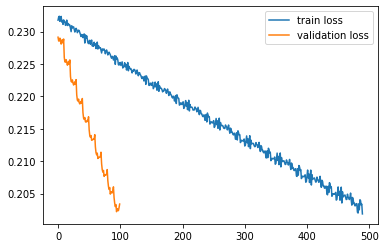

In [39]:
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
import numpy as np

batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
max_epochs = 10
learning_rate = 0.01

train_loss = []
val_loss = []

for epoch in range(max_epochs):
  for idx, data in enumerate(train_loader):
    features, labels = data
    features = features
    labels = labels
    probs = model(features.reshape([-1, 784]))
    loss = ce_loss(probs, labels)
    train_loss.append(loss.item())
    print("Epoch {0}/{1} Iteration {2}/{3} Loss : {4} ".format(epoch, max_epochs, idx, len(train_loader), loss))

    for param in model.parameters():
      param.grad = None
    loss.backward()

    for name, param in model.named_parameters():
      # Write paramtere update routine here:
      # --------------
      new_param = param - learning_rate*param.grad
      # --------------

      with torch.no_grad():
        param.copy_(new_param)

  # Write Validation routine here: 
  # ------------------------------


  corr, totl, conf_mat, conf_mat1 = 0, 0, 0, 0

  for idx, (features, labels) in enumerate(valid_loader):
    probs = model(features.reshape([-1, 784]))
    loss = ce_loss(probs, labels)
    val_loss.append(loss.item())
    pred = torch.argmax(probs, dim=1)
    corr += torch.sum(pred == labels).item()
    totl += len(labels)
    conf_mat += confusion_matrix(labels.cpu(), pred.cpu(), labels=[1,0])
    tn, fp, fn, tp = conf_mat.flatten()
    print(classification_report(labels.cpu().numpy(), pred.cpu().numpy()))

  np.seterr(invalid='ignore')

  accuracy = corr / totl
  recall = tp / (tp + fn)
  precision = tp / (tp + fp)
  f1 = 2 * ((recall * precision) / (recall + precision))
  roc_auc = roc_auc_score(labels.detach().cpu().numpy(), probs.detach().cpu().numpy(), multi_class='ovr')

  # ------------------------------
  print("----------------------------------")
  print("Epoch {0}/{1} Validation Loss : {2} ;".format(epoch, max_epochs, loss))
  print("Epoch {0}/{1} Validation Accuracy : {2} %".format(epoch, max_epochs, 100*accuracy))
  print("Epoch {0}/{1} Validation Recall : {2}".format(epoch, max_epochs, recall))
  print("Epoch {0}/{1} Validation Precision : {2}".format(epoch, max_epochs, precision))
  print("Epoch {0}/{1} Validation F1 Score : {2}".format(epoch, max_epochs, f1))
  print("Epoch {0}/{1} Validation ROC_AUC Score : {2}".format(epoch, max_epochs, roc_auc))
  print("----------------------------------")

# plot train and validation loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.show()

In [ ]:
## Write Relevant training and reporting code here:
#----------------------------------------------------
train_loss = []
val_loss = []

accuracyl = []
precisionl = []
recalll = []
f1_scorel = []
roc_aucl = []

for i in range(10):
  seed = random.randint(0, 1000)
  random.seed(seed)
  torch.manual_seed(seed)
  for epoch in range(max_epochs):
    for idx, data in enumerate(train_loader):
      features, labels = data
      features = features
      labels = labels
      probs = model(features.reshape([-1, 784]))
      loss = ce_loss(probs, labels)
      train_loss.append(loss.item())
      for param in model.parameters():
        param.grad = None
      loss.backward()
      for name, param in model.named_parameters():
        # Write paramtere update routine here:
        # --------------
        new_param = param - learning_rate*param.grad
        # --------------
        with torch.no_grad():
          param.copy_(new_param)
    # Write Validation routine here: 
    # ------------------------------
    correct = 0
    total = 0
    conf_mat = 0
    conf_mat1 = 0
    for idx, (features, labels) in enumerate(valid_loader):
      probs = model(features.reshape([-1, 784]))
      loss = ce_loss(probs, labels)
      val_loss.append(loss.item())
      pred = torch.argmax(probs, dim=1)
      corr += torch.sum(pred == labels).item()
      totl += len(labels)
      conf_mat += confusion_matrix(labels.cpu(), pred.cpu(), labels=[1,0])
      tn, fp, fn, tp = conf_mat.flatten()
    accuracyl.append(100*(accuracy))
    precisionl.append(precision)
    recalll.append(recall)
    f1_scorel.append(f1)
    roc_aucl.append(roc_auc)
        # ------------------------------
    print("----------------------------------")
    print("Epoch {0}/{1} Validation Loss : {2} ;".format(epoch, max_epochs, loss))
    print("Epoch {0}/{1} Validation Accuracy : {2} %".format(epoch, max_epochs, 100*accuracyl))
    print("Epoch {0}/{1} Validation Recall : {2}".format(epoch, max_epochs, recalll))
    print("Epoch {0}/{1} Validation Precision : {2}".format(epoch, max_epochs, precisionl))
    print("Epoch {0}/{1} Validation F1 Score : {2}".format(epoch, max_epochs, f1_scorel))
    print("Epoch {0}/{1} Validation ROC_AUC Score : {2}".format(epoch, max_epochs, roc_aucl))
    print("----------------------------------")


+ Change the number of parameters in the Neural Network 
  + Train an underfit model
  + Train a overfit model
  + Demostrate the difference between overfitting and underfitting. Give detailed reasoning.

To observe overfitting, you can increase the size of the model (i.e. number of parameters) by increasing the number of neurons in each layer, and by adding more layers to the network. This will result in the model having more capacity to fit the training data, but may lead to overfitting because it will have more chances to memorize the training data instead of learning general patterns.

To observe underfitting, you can reduce the size of the model (i.e. number of parameters) by decreasing the number of neurons in each layer, and by reducing the number of layers in the network. This will result in the model having less capacity to fit the training data, and may lead to underfitting because it will not have enough capacity to capture the complexity of the data.

So, for instance, you can modify the in_features and out_features as follows to see overfitting: 


In [ ]:
#for overfitting
''' self.layer_1 = torch.nn.Linear(in_features=784, out_features=1024)
self.layer_2 = torch.nn.Linear(in_features=1024, out_features=2048)
self.layer_3 = torch.nn.Linear(in_features=2048, out_features=10) '''

In [40]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    # Add Linear layers below 
    #-----------------------------------
    self.layer_1 = torch.nn.Linear(in_features=784, out_features=1024)
    self.layer_2 = torch.nn.Linear(in_features=1024, out_features=2048)
    self.layer_3 = torch.nn.Linear(in_features=2048, out_features=10)
    # ------------------------------------
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    # Apply layers defined above:
    #-------------------------------
    x = self.layer_1(x)
    x = self.activation(x)
    x = self.layer_2(x)
    output = self.softmax(x)
    #-------------------------------
    return output

In [ ]:
# Similarly for underfitting 
'''self.layer_1 = torch.nn.Linear(in_features=784, out_features=128)
self.layer_2 = torch.nn.Linear(in_features=128, out_features=64)
'''